In [18]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Integer
from skopt.plots import plot_convergence
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import Matern, RBF, RationalQuadratic
import matplotlib.pyplot as plt

class GQSOptimizer:
    def __init__(self, metrics_list, weight_range=(1, 5)):
        """
        Initialize the GQS optimizer with metrics data and weight range.
        
        Args:
            metrics_list (list): List of dictionaries containing graph metrics
            weight_range (tuple): Range for weight values (min, max)
        """
        self.metrics_list = metrics_list
        self.weight_range = weight_range
        self.results = {}
        self.best_kernel = None
        self.best_result = None

    def safe_division(self, x):
        """Handle division by zero gracefully"""
        return 1 / (x + 1e-6) if x >= 0 else 1.0

    def compute_gqs(self, metrics, weights):
        """
        Compute Graph Quality Score (GQS) for given metrics and weights.
        """
        try:
            terms = [
                weights[0] * metrics["oo_nni"],
                weights[1] * self.safe_division(metrics["sp_ch_a"]),
                weights[2] * self.safe_division(metrics["gs_bb_iar"]),
                weights[3] * (1 / (1 + max(metrics["nm_dm_imse"], 0))),
                weights[4] * (1 / (1 + max(metrics["eb_rsdd"], 0))),
                weights[5] * (1 / (1 + max(metrics["node_overlaps"], 0))),
                weights[6] * (1 / (1 + max(metrics["area_size"], 1e-6))),
                weights[7] * (1 / (1 + max(metrics["avg_node_size"], 1e-6)))
            ]
            
            score = sum(terms)
            return score / sum(weights)
        except Exception as e:
            print(f"Error in GQS calculation: {str(e)}")
            raise

    def objective(self, weights):
        """Objective function for optimization"""
        scores = [self.compute_gqs(metrics, weights) for metrics in self.metrics_list]
        return -np.mean(scores)  # Negative for minimization

    def optimize(self, n_calls=50, n_random_starts=10, random_state=42):
        """Run optimization with all available kernels"""
        kernels = {
            "Matern": Matern(),
            "RBF": RBF(), 
            "RQ": RationalQuadratic()
        }
        
        search_space = [
            Integer(self.weight_range[0], self.weight_range[1], name=f'w{i}')
            for i in range(8)
        ]

        best_score = -np.inf
        
        for kernel_name, kernel in kernels.items():
            print(f"\n🔍 Optimizing with {kernel_name} kernel...")
            try:
                result = gp_minimize(
                    func=self.objective,
                    dimensions=search_space,
                    n_calls=n_calls,
                    n_random_starts=n_random_starts,
                    base_estimator=GaussianProcessRegressor(kernel=kernel),
                    random_state=random_state
                )
                
                final_score = -result.fun
                self.results[kernel_name] = result

                if final_score > best_score:
                    best_score = final_score
                    self.best_kernel = kernel_name
                    self.best_result = result
                    
                print(f"✅ {kernel_name} optimization complete. Best GQS: {final_score:.4f}")
            except Exception as e:
                print(f"❌ Optimization failed for {kernel_name}: {str(e)}")

        if self.best_result is None:
            raise RuntimeError("All kernel optimizations failed!")
            
        print(f"\n🚀 Best Kernel: {self.best_kernel}")
        print(f"🏆 Best GQS: {best_score:.4f}")

    def get_results(self):
        """Return optimization results"""
        if self.best_result is None:
            raise ValueError("Optimization not run yet")
        return {
            "best_weights": self.best_result.x,
            "best_score": -self.best_result.fun,
            "best_kernel": self.best_kernel,
            "all_results": self.results
        }

    def plot_convergence(self):
        """Plot optimization convergence"""
        if self.best_result is None:
            raise ValueError("Optimization not run yet")
        plot_convergence(self.best_result)
        plt.title(f"Convergence ({self.best_kernel} kernel)")
        plt.show()

In [3]:
import json
import pandas as pd
import numpy as np
import os

class DataGenerator:
    def __init__(self, csv_path, json_path):
        self.csv_path = csv_path
        self.json_path = json_path
        self.metrics_list = []
        self.valid_rows = []
        
        # Algorithm name mapping between different naming conventions
        self.algorithm_map = {
            'initial': 'initial',
            'scale': 'SCALE',
            'pfs': 'PFS',
            'pfsp': "PFS'",
            'fta': 'FTA',
            'vpsc': 'VPSC',
            'prism': 'PRISM',
            'gtree': 'GTREE',
            'rwordle': 'RWordle-L',
            'rwordle-l': 'RWordle-L'
        }

    @staticmethod
    def calculate_area(box):
        _, _, w, h = box
        return w * h

    @staticmethod
    def calculate_avg_node_size(boxes):
        areas = [DataGenerator.calculate_area(box) for box in boxes]
        return np.mean(areas) if areas else 1e-6

    @staticmethod
    def calculate_area_size(boxes):
        if not boxes:
            return 1e-6
        x_min = min(box[0] for box in boxes)
        y_min = min(box[1] for box in boxes)
        x_max = max(box[0] + box[2] for box in boxes)
        y_max = max(box[1] + box[3] for box in boxes)
        return (x_max - x_min) * (y_max - y_min)

    @staticmethod
    def calculate_overlaps(boxes):
        """Improved overlap calculation with proper bounding box intersection"""
        overlaps = 0
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                # Box format: [x, y, width, height]
                box1 = boxes[i]
                box2 = boxes[j]
                
                # Calculate coordinates for box1
                x1_min, y1_min = box1[0], box1[1]
                x1_max, y1_max = x1_min + box1[2], y1_min + box1[3]
                
                # Calculate coordinates for box2
                x2_min, y2_min = box2[0], box2[1]
                x2_max, y2_max = x2_min + box2[2], y2_min + box2[3]
                
                # Check for overlap
                if not (x1_max <= x2_min or x2_max <= x1_min or 
                        y1_max <= y2_min or y2_max <= y1_min):
                    overlaps += 1
            print (overlaps)
        return overlaps

    def normalize_algorithm_name(self, algo_name):
        """Convert algorithm name to standardized format"""
        lower_name = algo_name.lower().strip()
        return self.algorithm_map.get(lower_name, algo_name)

    def load_data(self):
        """Load and validate data from files"""
        try:
            df = pd.read_csv(self.csv_path, sep=";")
            # Normalize algorithm names in CSV
            if 'algorithm' in df.columns:
                df['algorithm'] = df['algorithm'].apply(self.normalize_algorithm_name)
        except Exception as e:
            raise ValueError(f"Error loading CSV file: {str(e)}")

        try:
            with open(self.json_path, "r") as f:
                layout_data = json.load(f)
            layout_lookup = {}
            for entry in layout_data:
                # Normalize algorithm names in JSON keys
                normalized_entry = {'base_name': entry['base_name']}
                for algo, boxes in entry.items():
                    if algo != 'base_name':
                        normalized_algo = self.normalize_algorithm_name(algo)
                        normalized_entry[normalized_algo] = boxes
                layout_lookup[entry['base_name']] = normalized_entry
        except Exception as e:
            print(f"Warning: Error loading JSON file, continuing without layout data: {str(e)}")
            layout_lookup = {}

        return df, layout_lookup

    def generate_metrics(self):
        """Generate metrics from loaded data"""
        df, layout_lookup = self.load_data()
        skipped_count = 0

        for _, row in df.iterrows():
            # Skip rows with missing essential metrics
            if row[["oo_nni", "sp_ch_a", "gs_bb_iar", "nm_dm_imse", "eb_rsdd"]].isnull().any():
                skipped_count += 1
                continue

            type_ = row["type"]
            n = int(row["n"])
            iteration = int(row["iteration"])
            algo = self.normalize_algorithm_name(row["algorithm"])
            filename = f"{type_}_{n}_{iteration}"

            # Initialize default values
            node_overlaps = 0
            area_size = 1e6
            avg_node_size = 1e3

            # Use layout data if available
            if layout_lookup and filename in layout_lookup and algo in layout_lookup[filename]:
                try:
                    boxes = layout_lookup[filename][algo]
                    if boxes:  # Only calculate if boxes exist
                        node_overlaps = self.calculate_overlaps(boxes)
                        area_size = self.calculate_area_size(boxes)
                        avg_node_size = self.calculate_avg_node_size(boxes)
                except Exception as e:
                    print(f"Warning: Error processing layout for {filename}/{algo}: {str(e)}")

            metrics = {
                "oo_nni": row["oo_nni"],
                "sp_ch_a": row["sp_ch_a"],
                "gs_bb_iar": row["gs_bb_iar"],
                "nm_dm_imse": row["nm_dm_imse"],
                "eb_rsdd": row["eb_rsdd"],
                "node_overlaps": node_overlaps,
                "area_size": area_size,
                "avg_node_size": avg_node_size
            }

            if not any(pd.isnull(val) for val in metrics.values()):
                self.metrics_list.append(metrics)
                self.valid_rows.append((filename, algo, metrics))
            else:
                skipped_count += 1

        print(f"\n📊 Data Generation Complete:")
        print(f"- Valid entries: {len(self.metrics_list)}")
        print(f"- Skipped entries: {skipped_count}")
        
        return self.metrics_list, self.valid_rows

    def save_processed_data(self, output_path="processed_metrics2.csv"):
        """Save processed data for later use"""
        if not self.valid_rows:
            raise ValueError("No valid data to save")
            
        data_to_save = []
        for filename, algo, metrics in self.valid_rows:
            data_to_save.append({
                "filename": filename,
                "algorithm": algo,
                **metrics
            })
            
        pd.DataFrame(data_to_save).to_csv(output_path, index=False)
        print(f"✅ Processed data saved to {output_path}")

In [4]:
import pandas as pd

print("📂 Generating data...")
data_gen = DataGenerator(
        csv_path="generated-evaluation.csv",
        json_path="final_merged_with_initial.json"
    )
    

metrics_list, valid_rows = data_gen.generate_metrics()
data_gen.save_processed_data("processed_metrics2.csv")


📂 Generating data...
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1

🚀 Starting GQS Optimization Pipeline

📂 Generating data...

📊 Data Generation Complete:
- Valid entries: 6720
- Skipped entries: 0
✅ Processed data saved to processed_metrics.csv

⚙️ Starting optimization...

🔍 Optimizing with Matern kernel...
✅ Matern optimization complete. Best GQS: 0.7270

🔍 Optimizing with RBF kernel...
✅ RBF optimization complete. Best GQS: 0.7270

🔍 Optimizing with RQ kernel...
✅ RQ optimization complete. Best GQS: 0.7270

🚀 Best Kernel: Matern
🏆 Best GQS: 0.7270

🥇 Optimization Results:
- Best Kernel: Matern
- Best GQS: 0.7270
- Best Weights: ['1.00', '1.00', '5.00', '1.00', '5.00', '5.00', '1.00', '1.00']


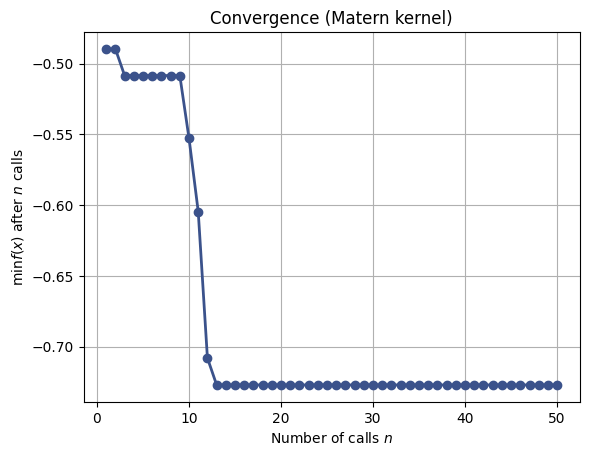


💾 Saving final results...
✅ Final results saved to final_results.csv


In [20]:

import pandas as pd

def main():
    print("🚀 Starting GQS Optimization Pipeline\n")
    
    # 1. Data Generation Phase
    print("📂 Generating data...")
    data_gen = DataGenerator(
        csv_path="generated-evaluation.csv",
        json_path="final_merged_with_initial.json"
    )
    
    try:
        metrics_list, valid_rows = data_gen.generate_metrics()
        data_gen.save_processed_data("processed_metrics.csv")
    except Exception as e:
        print(f"❌ Data generation failed: {str(e)}")
        return

    # 2. Optimization Phase
    print("\n⚙️ Starting optimization...")
    optimizer = GQSOptimizer(metrics_list)
    
    try:
        optimizer.optimize(n_calls=50, n_random_starts=10)
        results = optimizer.get_results()
        
        print("\n🥇 Optimization Results:")
        print(f"- Best Kernel: {results['best_kernel']}")
        print(f"- Best GQS: {results['best_score']:.4f}")
        print("- Best Weights:", [f"{w:.2f}" for w in results['best_weights']])
        
        optimizer.plot_convergence()
        
        # 3. Save Final Results
        print("\n💾 Saving final results...")
        final_results = []
        best_weights = results['best_weights']
        
        for filename, algo, metrics in valid_rows:
            try:
                gqs = optimizer.compute_gqs(metrics, best_weights)
                final_results.append({
                    "filename": filename,
                    "algorithm": algo,
                    "GQS": round(gqs, 4),
                    **{k: round(v, 4) if isinstance(v, float) else v 
                       for k, v in metrics.items()}
                })
            except Exception as e:
                print(f"⚠️ Error processing {filename}: {str(e)}")
        
        pd.DataFrame(final_results).to_csv("final_results.csv", index=False)
        print("✅ Final results saved to final_results.csv")
        
    except Exception as e:
        print(f"❌ Optimization failed: {str(e)}")

if __name__ == "__main__":
    main()